In [23]:

import numpy as np
from tqdm.notebook import tqdm

up_stable = np.load("stable.mp4.npy") # label 1
down_stable = np.load("legwork-up.MOV.npy") # label 0

up_stable = up_stable.reshape((-1,34))
down_stable = down_stable.reshape((-1,34))

X_data = np.concatenate((up_stable, down_stable))
Y_data = np.zeros(up_stable.shape[0] + down_stable.shape[0], dtype=bool)
Y_data[0:len(up_stable)] = 1


In [24]:
# degree augmentation
new_X = []
new_Y = []

for x,y in tqdm(zip(X_data, Y_data), total=len(X_data)):

    t = 0
    while True:
        theta = np.pi/5 - np.pi/14 * t
        t+=1
        if theta < - np.pi/5:
            break
        M = np.array([[np.cos(theta), -np.sin(theta)],
        [np.sin(theta), np.cos(theta)]])
        temp_coord_list = []
        for coord_of_x in x.reshape(17,2):
            temp_coord_list.append(np.matmul(M, coord_of_x))
        new_X.append(np.array(temp_coord_list).reshape(34))
        new_Y.append(y)

X_data = np.array(new_X)
Y_data = np.array(new_Y)




  0%|          | 0/2711 [00:00<?, ?it/s]

In [25]:
from sklearn.model_selection import train_test_split



X_train, X_test, y_train, y_test = train_test_split(X_data,
                                                    Y_data,
                                                    test_size=0.2,
                                                    shuffle=True,
                                                    random_state=1008)

In [26]:
from sklearn.metrics import confusion_matrix
from pprint import pprint

from sklearn.linear_model import LogisticRegressionCV

cls = LogisticRegressionCV(cv=10, scoring='accuracy', solver='liblinear',
                           max_iter=1000, class_weight='balanced',
                           n_jobs=-1)

cls.fit(X=X_train, y=y_train)
pred = cls.predict(X_test)
pprint(confusion_matrix(y_test, pred))


print(cls.intercept_)
pprint(cls.coef_[0])

array([[1077,    0],
       [   0, 2177]])
[-0.0064572]
array([ 0.27395424,  0.19056958,  0.37826845,  0.16923755,  0.36954079,
        0.08355617,  0.19621233,  0.12534303,  0.34382072, -0.08534732,
       -0.22024501,  0.06042802, -0.12605909, -0.21088386, -0.66647873,
       -0.0786242 ,  0.41105374, -0.54597065,  0.11992584,  0.08517378,
        0.32553463,  0.14749978, -0.08684407, -0.12913078,  0.08684407,
        0.12913078, -0.23627454, -0.58882022,  0.88215188,  2.16772089,
        0.0334784 ,  0.574739  ,  0.5904212 ,  0.62181658])


2.4.1
Epoch 1/20
51/51 [==============================] - 0s 2ms/step - loss: 0.7062 - accuracy: 0.6643 - val_loss: 0.4963 - val_accuracy: 0.6896
Epoch 2/20
51/51 [==============================] - 0s 819us/step - loss: 0.4532 - accuracy: 0.7727 - val_loss: 0.3181 - val_accuracy: 0.9948
Epoch 3/20
51/51 [==============================] - 0s 845us/step - loss: 0.2805 - accuracy: 0.9963 - val_loss: 0.2026 - val_accuracy: 0.9988
Epoch 4/20
51/51 [==============================] - 0s 807us/step - loss: 0.1826 - accuracy: 0.9991 - val_loss: 0.1390 - val_accuracy: 0.9997
Epoch 5/20
51/51 [==============================] - 0s 959us/step - loss: 0.1282 - accuracy: 1.0000 - val_loss: 0.0982 - val_accuracy: 0.9997
Epoch 6/20
51/51 [==============================] - 0s 1ms/step - loss: 0.0901 - accuracy: 1.0000 - val_loss: 0.07

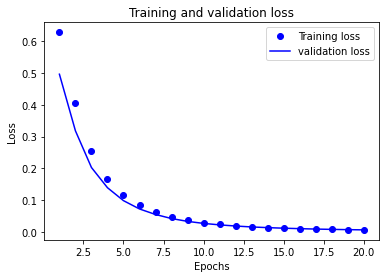

In [27]:
%matplotlib inline

# tensorflow와 tf.keras를 임포트합니다
import tensorflow as tf
from tensorflow import keras


import matplotlib.pyplot as plt

print(tf.__version__)

model = keras.Sequential([
    keras.layers.Dense(15, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics =['accuracy'])

history = model.fit(X_train, y_train, epochs=20,
                    batch_size=256, validation_data=(X_test,y_test))
history_dic = history.history
history_dic.keys()


history_dic = history.history
loss = history_dic['loss']
val_loss = history_dic['val_loss']

epochs = range(1, len(loss)+1)
plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [28]:
pred = model.predict(X_test)
pred[np.where(pred<0.5)] = 0
pred[np.where(pred>=0.5)] = 1
pred = pred.astype(np.bool).reshape(pred.shape[0])
y_test

pprint(confusion_matrix(y_test, pred))

array([[1077,    0],
       [   0, 2177]])


In [29]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open('legwork-model.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmp1gtay0p9/assets


INFO:tensorflow:Assets written to: /tmp/tmp1gtay0p9/assets
